# MIPD of warfarin

In [1]:
import os

import chi
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import myokit
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme()

from model import define_wajima_model

Define convenience functions

In [13]:
def get_vk_consumption(days, nids, seed):
    """
    Returns deviations of the vk consumption from the mean consumption drawn
    from a normal distribution of shape (days, n_ids).
    """
    rng = np.random.default_rng(seed)
    vk_input = rng.normal(loc=1, scale=0.1, size=(days, nids))

    return vk_input


def define_dosing_regimen(doses, delays, cal_time=100*24):
    """
    Returns a dosing regimen with delayed administration times.
    """
    duration = 0.01
    regimen = myokit.Protocol()
    for day, dose in enumerate(doses):
        if dose == 0:
            continue
        regimen.add(myokit.ProtocolEvent(
            level=dose/duration,
            start=cal_time+day*24+delays[day],
            duration=duration))

    return regimen


def terminate_trial(inrs, doses):
    """
    Returns 2 np.ndarrays of (n_completed, n_times) and 
    (n_terminated, n_times).

    We filter individuals based on their INR measurements. If the three 
    consecutive INR measurements of an individual are above 5 and the dose is 
    not being reduced, the trial is terminated for the individual.

    Parameters
    ----------
    inrs : np.ndarray of shape (ids, n_times)
    doses : np.ndarray of shape (ids, n_times-1)
    """
    thresold = 5

    ids_completed = []
    ids_terminated = []
    for _id, measurements in enumerate(inrs):
        # Quick filter: If there 2 or less measurements above the threshold, 
        # the individual goes into the completed bin
        is_above_threshold = measurements > thresold
        if np.sum(is_above_threshold) < 3:
            ids_completed.append(_id)
            continue

        # If there are no consecutive measurements above the threshold, the
        # individual goes into the completed bin
        is_consecutively_above_threshold = \
            is_above_threshold[:-3] \
            & is_above_threshold[1:-2] \
            & is_above_threshold[2:-1]
        if not np.any(is_consecutively_above_threshold):
            ids_completed.append(_id)
            continue

        # If the dose is lowered relative to the first occurance of the above
        # threshold measurement for all instances where we saw 3 consecutive
        # measurements were above the threshold, the individual goes into the 
        # completed bin
        is_dose_lower = doses[_id, 2:] < doses[_id, :-2]
        if np.any(is_consecutively_above_threshold & is_dose_lower):
            ids_completed.append(_id)
            continue

        ids_terminated.append(_id)

    return inrs[ids_completed], inrs[ids_terminated]

## Visualise demographics of trial cohort

/var/folders/v4/97p50d2s59d8tf5xm5h27fjh0000gp/T/ipykernel_9111/513827709.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cyp.append(cyp_decoder[int(temp['CYP2C9'].values)])
/var/folders/v4/97p50d2s59d8tf5xm5h27fjh0000gp/T/ipykernel_9111/513827709.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  vkorc.append(vkorc_decoder[int(temp['VKORC1'].values)])
/var/folders/v4/97p50d2s59d8tf5xm5h27fjh0000gp/T/ipykernel_9111/513827709.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprec

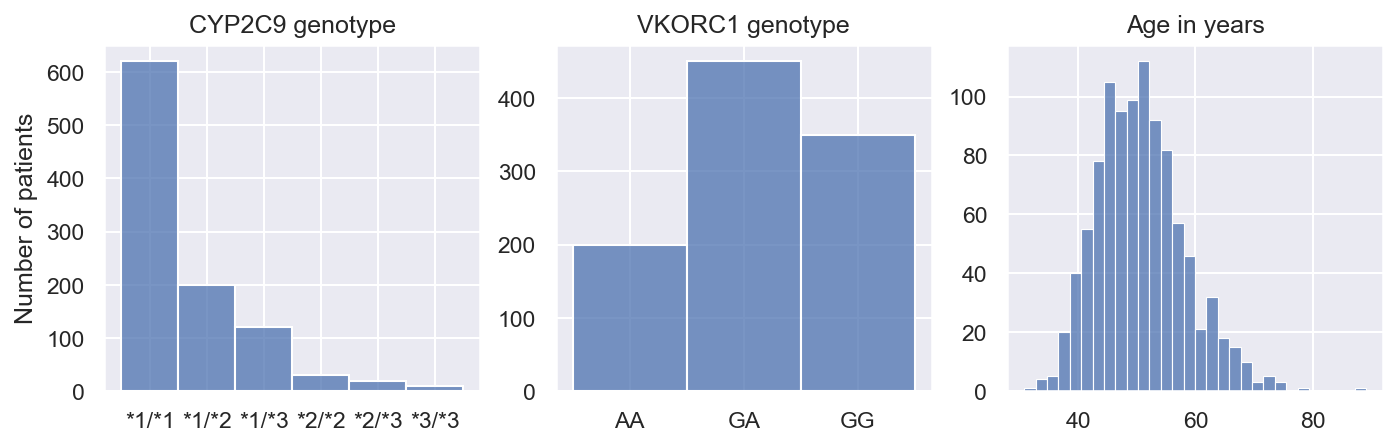

In [3]:
# Import data
directory = os.path.dirname(os.getcwd())
df_demo = pd.read_csv(directory + '/data/mipd_trial_cohort.csv')

# Reshape data
ids = df_demo.ID.dropna().unique()
cyp = []
vkorc = []
age = np.empty(len(ids))
cyp_decoder = {
    0: '*1/*1', 1: '*1/*2', 2: '*1/*3', 3: '*2/*2', 4: '*2/*3', 5: '*3/*3'}
vkorc_decoder = {0: 'GG', 1: 'GA', 2: 'AA'}
for idx, _id in enumerate(ids):
    temp = df_demo[df_demo.ID == _id]
    cyp.append(cyp_decoder[int(temp['CYP2C9'].values)])
    vkorc.append(vkorc_decoder[int(temp['VKORC1'].values)])
    age[idx] = temp['Age'].values
cyp.sort()
vkorc.sort()

# Create layout
fontsize = 11
my_dpi = 192
fig = plt.figure(figsize=(2250 // my_dpi, 700 // my_dpi), dpi=150)
outer = gridspec.GridSpec(1, 3, hspace=2.5)

# Create axes
axes = []
axes.append(plt.Subplot(fig, outer[0]))
axes.append(plt.Subplot(fig, outer[1]))
axes.append(plt.Subplot(fig, outer[2]))

# Add axes to figure
for ax in axes:
    fig.add_subplot(ax)

# Plot CYP2C9 distribution
sns.histplot(cyp, ax=axes[0])
sns.histplot(vkorc, ax=axes[1])
sns.histplot(age, ax=axes[2])

# Label axes
titles = ['CYP2C9 genotype', 'VKORC1 genotype', 'Age in years']
ylabels = ['Number of patients', '', '']
for ida, ax in enumerate(axes):
    ax.set_title(titles[ida])
    ax.set_ylabel(ylabels[ida])

plt.savefig('7_mipd_trial_demographics.pdf', bbox_inches='tight')
plt.savefig('7_mipd_trial_demographics.tif', bbox_inches='tight')

plt.show()

## Evaluate regression model

Simulate INR response for predicted dosing regimens

In [38]:
# Define model
model, _ = define_wajima_model(patient=True, inr_test=True)

# Get patient parameters
ids = df_demo.ID.dropna().unique()
parameters = np.empty(shape=(len(ids), model.n_parameters()))
for idx, _id in enumerate(ids):
    temp = df_demo[df_demo.ID == _id]
    parameters[idx] = temp[model.parameters()].values[0]

# Load dosing strategy
directory = os.path.dirname(os.getcwd())
df_doses = pd.read_csv(
    directory + '/3_regression_model'
    '/mipd_trial_predicted_dosing_regimens_deep_regression.csv')

# Convert dosing strategy to dosing regimens
# The induction doses are fixed to 10, 5 on days 1 and 2
days = 19
cal_time = 100 * 24
duration = 0.01
dosing_regimens = {}
doses = np.empty(shape=(len(df_doses.ID.dropna().unique()), days))
for idx, _id in enumerate(df_doses.ID.dropna().unique()):
    temp = df_doses[df_doses.ID == _id]
    doses[idx] = np.array([temp['Maintenance dose'].values[0]] * (days))

# Define IOV and EV
ids = df_doses.ID.dropna().unique()
rng = np.random.default_rng(seed=4)
delays = rng.exponential(scale=0.5, size=(days, len(ids)))
vk_input = get_vk_consumption(days+1, len(ids), seed=14)

# Simulate INR response to treatment
times = cal_time + np.arange(0, days+1) * 24
inrs_1 = np.empty(shape=(len(ids), len(times)))
error_model = chi.LogNormalErrorModel()
for idx, _id in enumerate(ids):
    # Set dosing regimen
    dr = define_dosing_regimen(doses[idx], delays=delays[:, idx])
    model.set_dosing_regimen(dr)

    # Simulate treatment response
    mask = ids == _id
    inrs_1[idx] = model.simulate(
        parameters=parameters[mask][0], times=times, vk_input=vk_input[:, idx])
    # Add noise
    inrs_1[idx] = error_model.sample(
        parameters=df_demo['Sigma log'].unique(), model_output=inrs_1[idx])[:, 0]

INFO:root:running build_ext
INFO:root:building 'myokit_sim_4_6273078967933757666' extension
INFO:root:creating build
INFO:root:creating build/temp.macosx-10.9-universal2-cpython-39
INFO:root:creating build/temp.macosx-10.9-universal2-cpython-39/var
INFO:root:creating build/temp.macosx-10.9-universal2-cpython-39/var/folders
INFO:root:creating build/temp.macosx-10.9-universal2-cpython-39/var/folders/v4
INFO:root:creating build/temp.macosx-10.9-universal2-cpython-39/var/folders/v4/97p50d2s59d8tf5xm5h27fjh0000gp
INFO:root:creating build/temp.macosx-10.9-universal2-cpython-39/var/folders/v4/97p50d2s59d8tf5xm5h27fjh0000gp/T
INFO:root:creating build/temp.macosx-10.9-universal2-cpython-39/var/folders/v4/97p50d2s59d8tf5xm5h27fjh0000gp/T/tmpx0kn0h7bmyokit
INFO:root:clang -Wno-unused-result -Wsign-compare -Wunreachable-code -fno-common -dynamic -DNDEBUG -g -fwrapv -O3 -Wall -iwithsysroot/System/Library/Frameworks/System.framework/PrivateHeaders -iwithsysroot/Applications/Xcode.app/Contents/Develo

Dropouts

In [39]:
_, terminated_1 = terminate_trial(inrs_1, doses)
terminated_1.shape

(17, 20)

In [40]:
np.max(terminated_1)

8.450479327148361

Visualise treatment response

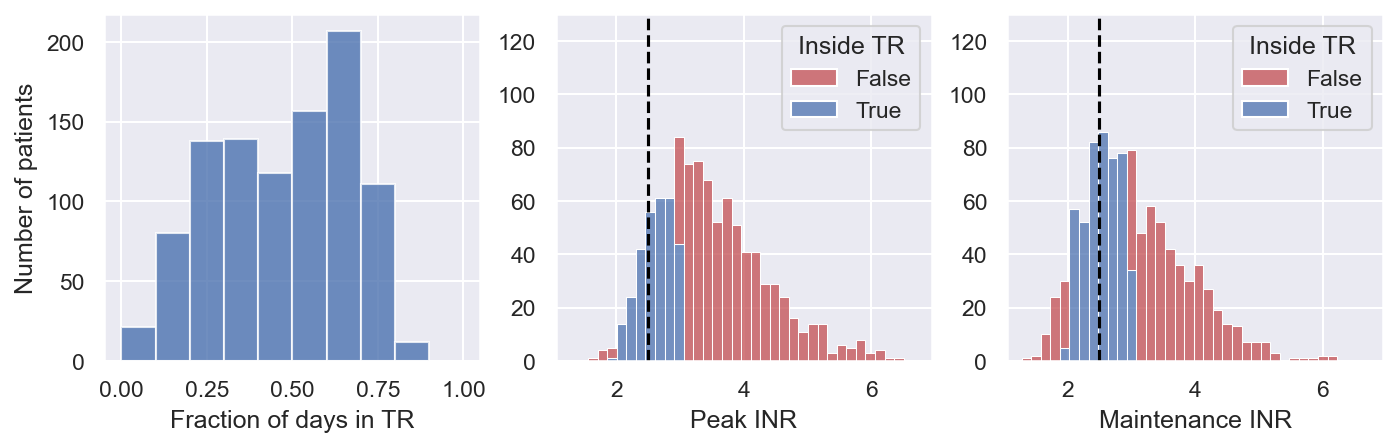

In [41]:
# Create layout
fontsize = 11
my_dpi = 192
fig = plt.figure(figsize=(2250 // my_dpi, 700 // my_dpi), dpi=150)
outer = gridspec.GridSpec(1, 3, hspace=2.5)

# Create axes
axes = []
axes.append(plt.Subplot(fig, outer[0]))
axes.append(plt.Subplot(fig, outer[1]))
axes.append(plt.Subplot(fig, outer[2]))

# Add axes to figure
for ax in axes:
    fig.add_subplot(ax)

# Exclude individuals with terminated trials
completed_1, terminated_1 = terminate_trial(inrs_1, doses)

# Plot time in therapeutic range
in_tr = (completed_1 >= 2) & (completed_1 <= 3)
ttr = np.mean(in_tr, axis=1)
axes[0].hist(
    ttr, bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
    color=sns.color_palette()[0], alpha=0.8)

# Plot distribution of peak INR
max_inrs = np.max(completed_1, axis=1)
df = pd.DataFrame({
    'INR': max_inrs, 'Inside TR': (max_inrs>=2) & (max_inrs<=3)})
sns.histplot(
    df, x='INR', hue='Inside TR', ax=axes[1], multiple='stack',binwidth=0.15,
    palette=[sns.color_palette()[3], sns.color_palette()[0]])
axes[1].axvline(x=2.5, color='black', linestyle='dashed')

# # Plot maintenance INR distirbution
final_inrs = completed_1[:, -1]
df = pd.DataFrame({
    'INR': final_inrs, 'Inside TR': (final_inrs>=2) & (final_inrs<=3)})
sns.histplot(
    df, x='INR', hue='Inside TR', ax=axes[2], multiple='stack', binwidth=0.15,
    palette=[sns.color_palette()[3], sns.color_palette()[0]])
axes[2].axvline(x=2.5, color='black', linestyle='dashed')


# Label axes
axes[0].set_xlabel('Fraction of days in TR')
axes[0].set_ylabel('Number of patients')
axes[0].set_xlim([-0.05, 1.05])
axes[1].set_xlabel('Peak INR')
axes[1].set_ylabel('')
axes[1].set_xlim([1.05, 6.95])
axes[1].set_ylim([0, 130])
axes[2].set_xlabel('Maintenance INR')
axes[2].set_ylabel('')
axes[2].set_xlim([1.05, 6.95])
axes[2].set_ylim([0, 130])

# plt.savefig('7_mipd_trial_results_deep_regression.pdf', bbox_inches='tight')
# plt.savefig('7_mipd_trial_results_deep_regression.tif', bbox_inches='tight')

plt.show()

## Evaluate DQN model

In [42]:
# Load dosing strategy
directory = os.path.dirname(os.getcwd())
data = pd.read_csv(
    directory + '/4_reinforcement_learning'
    '/mipd_trial_predicted_dosing_regimens.csv')

ids = data.ID.dropna().unique()
n_obs = data[data.ID == ids[0]]['Number of observations'].unique()
inrs_3 = np.empty((len(ids), len(n_obs), 3))
for idx, _id in enumerate(ids):
    temp = data[data.ID == _id]
    for idn, n in enumerate(n_obs):
        inrs_3[idx, idn, 0] = n - 1  # Time in days
        inrs_3[idx, idn, 1] = temp[
            temp['Number of observations'] == n].INR.values
        inrs_3[idx, idn, 2] = temp[
            temp['Number of observations'] == n]['Dose %d in mg' % n].values

/var/folders/v4/97p50d2s59d8tf5xm5h27fjh0000gp/T/ipykernel_9111/2475560427.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  inrs_3[idx, idn, 1] = temp[
/var/folders/v4/97p50d2s59d8tf5xm5h27fjh0000gp/T/ipykernel_9111/2475560427.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  inrs_3[idx, idn, 2] = temp[


Dropouts

In [43]:
_, terminated_3 = terminate_trial(inrs_3[:, :, 1], inrs_3[:, :-1, 2])
terminated_3.shape

(10, 19)

In [44]:
np.max(terminated_3)

29.034217233294864

Visualise treatment response

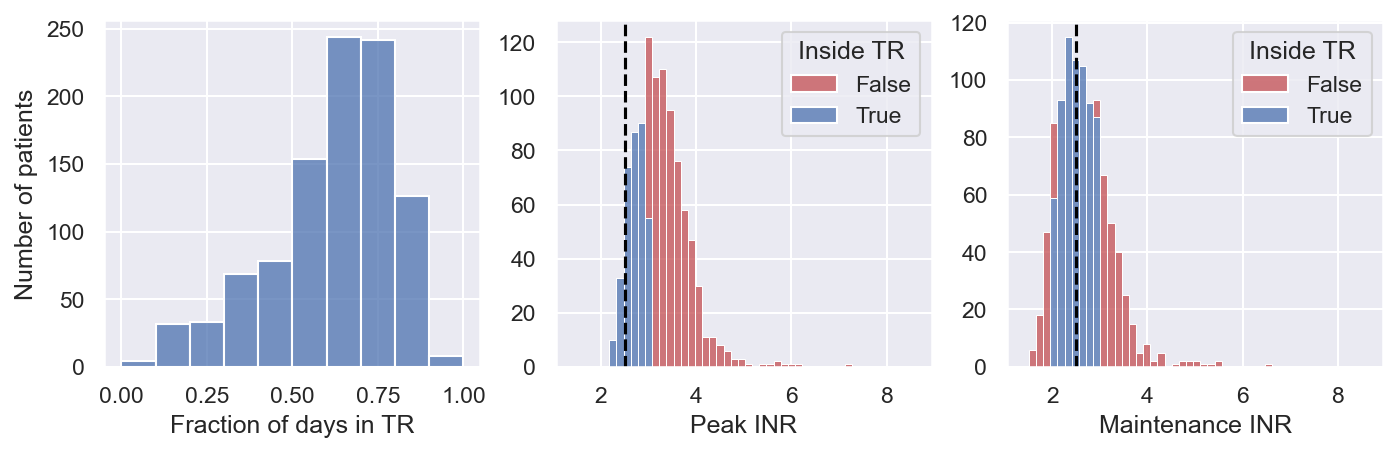

In [45]:
# Create layout
fontsize = 11
my_dpi = 192
fig = plt.figure(figsize=(2250 // my_dpi, 700 // my_dpi), dpi=150)
outer = gridspec.GridSpec(1, 3, hspace=2.5)

# Create axes
axes = []
axes.append(plt.Subplot(fig, outer[0]))
axes.append(plt.Subplot(fig, outer[1]))
axes.append(plt.Subplot(fig, outer[2]))

# Add axes to figure
for ax in axes:
    fig.add_subplot(ax)

# Exclude individuals with terminated trials
completed_3, terminated_3 = terminate_trial(inrs_3[:, :, 1], inrs_3[:, :-1, 2])

# Plot time in therapeutic range
in_tr = (completed_3 >= 2) & (completed_3 <= 3)
ttr = np.mean(in_tr, axis=1)
sns.histplot(
    ttr, ax=axes[0], bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

# Plot distribution of peak INR
max_inrs = np.max(completed_3, axis=1)
df = pd.DataFrame({
    'INR': max_inrs, 'Inside TR': (max_inrs>=2) & (max_inrs<=3)})
sns.histplot(
    df, x='INR', hue='Inside TR', ax=axes[1], multiple='stack', binwidth=0.15,
    palette=[sns.color_palette()[3], sns.color_palette()[0]])
axes[1].axvline(x=2.5, color='black', linestyle='dashed')

# Plot maintenance INR distirbution
final_inrs = completed_3[:, -1]
df = pd.DataFrame({
    'INR': final_inrs, 'Inside TR': (final_inrs>=2) & (final_inrs<=3)})
sns.histplot(
    df, x='INR', hue='Inside TR', ax=axes[2], multiple='stack', binwidth=0.15,
    palette=[sns.color_palette()[3], sns.color_palette()[0]])
axes[2].axvline(x=2.5, color='black', linestyle='dashed')

# Label axes
axes[0].set_xlabel('Fraction of days in TR')
axes[0].set_ylabel('Number of patients')
axes[0].set_xlim([-0.05, 1.05])
axes[1].set_xlabel('Peak INR')
axes[1].set_ylabel('')
axes[1].set_xlim([1.05, 8.95])
axes[2].set_xlabel('Maintenance INR')
axes[2].set_ylabel('')
axes[2].set_xlim([1.05, 8.95])

# plt.savefig(
#     '9_mipd_trial_results_dqn.pdf', bbox_inches='tight')
# plt.savefig(
#     '9_mipd_trial_results_dqn.tif', bbox_inches='tight')

plt.show()

## Evaluate PKPD model

In [46]:
# Load dosing strategy
directory = os.path.dirname(os.getcwd())
data = pd.read_csv(
    directory + '/2_semi_mechanistic_model'
    '/mipd_trial_predicted_dosing_regimens.csv')

ids = data.ID.dropna().unique()
n_obs = data[data.ID == ids[0]]['Number of observations'].unique()
n_obs = n_obs[n_obs > 0]
inrs_4 = np.empty((len(ids), len(n_obs), 3))
for idx, _id in enumerate(ids):
    temp = data[data.ID == _id]
    for idn, n in enumerate(n_obs):
        inrs_4[idx, idn, 0] = n - 1  # Time in days
        inrs_4[idx, idn, 1] = temp[
            temp['Number of observations'] == n].INR.values
        inrs_4[idx, idn, 2] = temp[
            temp['Number of observations'] == n]['Dose %d in mg' % n].values

/var/folders/v4/97p50d2s59d8tf5xm5h27fjh0000gp/T/ipykernel_9111/931383444.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  inrs_4[idx, idn, 1] = temp[
/var/folders/v4/97p50d2s59d8tf5xm5h27fjh0000gp/T/ipykernel_9111/931383444.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  inrs_4[idx, idn, 2] = temp[


Dropouts

In [47]:
_, terminated_4 = terminate_trial(inrs_4[:, :, 1], inrs_4[:, :-1, 2])
terminated_4.shape

(0, 19)

Visualise treatment response

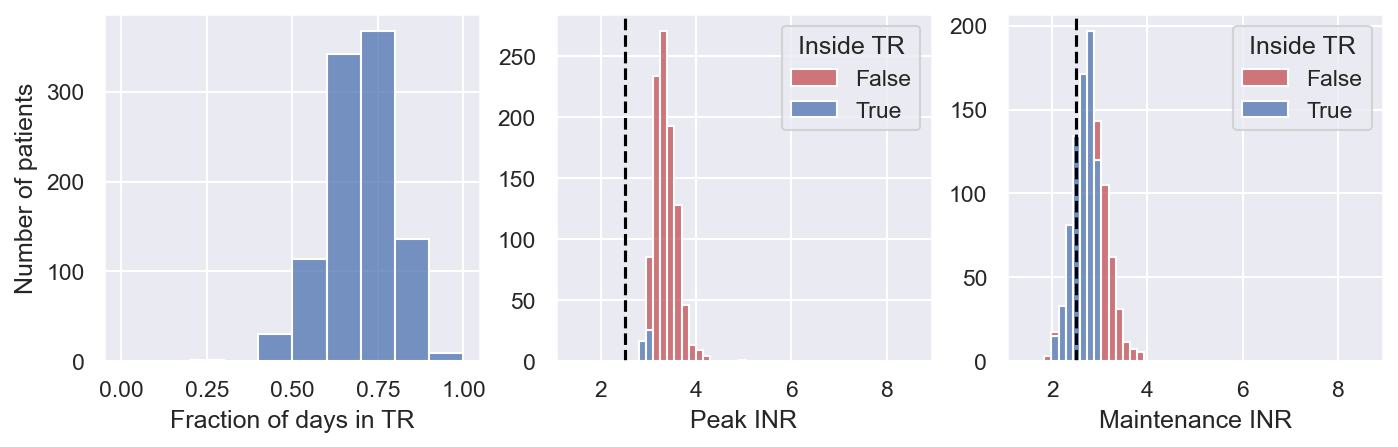

In [48]:
# Create layout
fontsize = 11
my_dpi = 192
fig = plt.figure(figsize=(2250 // my_dpi, 700 // my_dpi), dpi=150)
outer = gridspec.GridSpec(1, 3, hspace=2.5)

# Create axes
axes = []
axes.append(plt.Subplot(fig, outer[0]))
axes.append(plt.Subplot(fig, outer[1]))
axes.append(plt.Subplot(fig, outer[2]))

# Add axes to figure
for ax in axes:
    fig.add_subplot(ax)

# Exclude individuals with terminated trials
completed_4, terminated_4 = terminate_trial(inrs_4[:, :, 1], inrs_4[:, :-1, 2])

# Plot time in therapeutic range
in_tr = (completed_4 >= 2) & (completed_4 <= 3)
ttr = np.mean(in_tr, axis=1)
sns.histplot(
    ttr, ax=axes[0], bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

# Plot distribution of peak INR
max_inrs = np.max(completed_4, axis=1)
df = pd.DataFrame({
    'INR': max_inrs, 'Inside TR': (max_inrs>=2) & (max_inrs<=3)})
sns.histplot(
    df, x='INR', hue='Inside TR', ax=axes[1], multiple='stack', binwidth=0.15,
    palette=[sns.color_palette()[3], sns.color_palette()[0]])
axes[1].axvline(x=2.5, color='black', linestyle='dashed')

# # Plot maintenance INR distirbution
final_inrs = completed_4[:, -1]
df = pd.DataFrame({
    'INR': final_inrs, 'Inside TR': (final_inrs>=2) & (final_inrs<=3)})
sns.histplot(
    df, x='INR', hue='Inside TR', ax=axes[2], multiple='stack', binwidth=0.15,
    palette=[sns.color_palette()[3], sns.color_palette()[0]])
axes[2].axvline(x=2.5, color='black', linestyle='dashed')

# Label axes
axes[0].set_xlabel('Fraction of days in TR')
axes[0].set_ylabel('Number of patients')
axes[0].set_xlim([-0.05, 1.05])
axes[1].set_xlabel('Peak INR')
axes[1].set_ylabel('')
axes[1].set_xlim([1.05, 8.95])
axes[2].set_xlabel('Maintenance INR')
axes[2].set_ylabel('')
axes[2].set_xlim([1.05, 8.95])

# plt.savefig(
#     '10_mipd_trial_results_pkpd_model_BDRO_7_tdm.pdf', bbox_inches='tight')
# plt.savefig(
#     '10_mipd_trial_results_pkpd_model_BDRO_7_tdm.tif', bbox_inches='tight')

plt.show()

## Summary figure

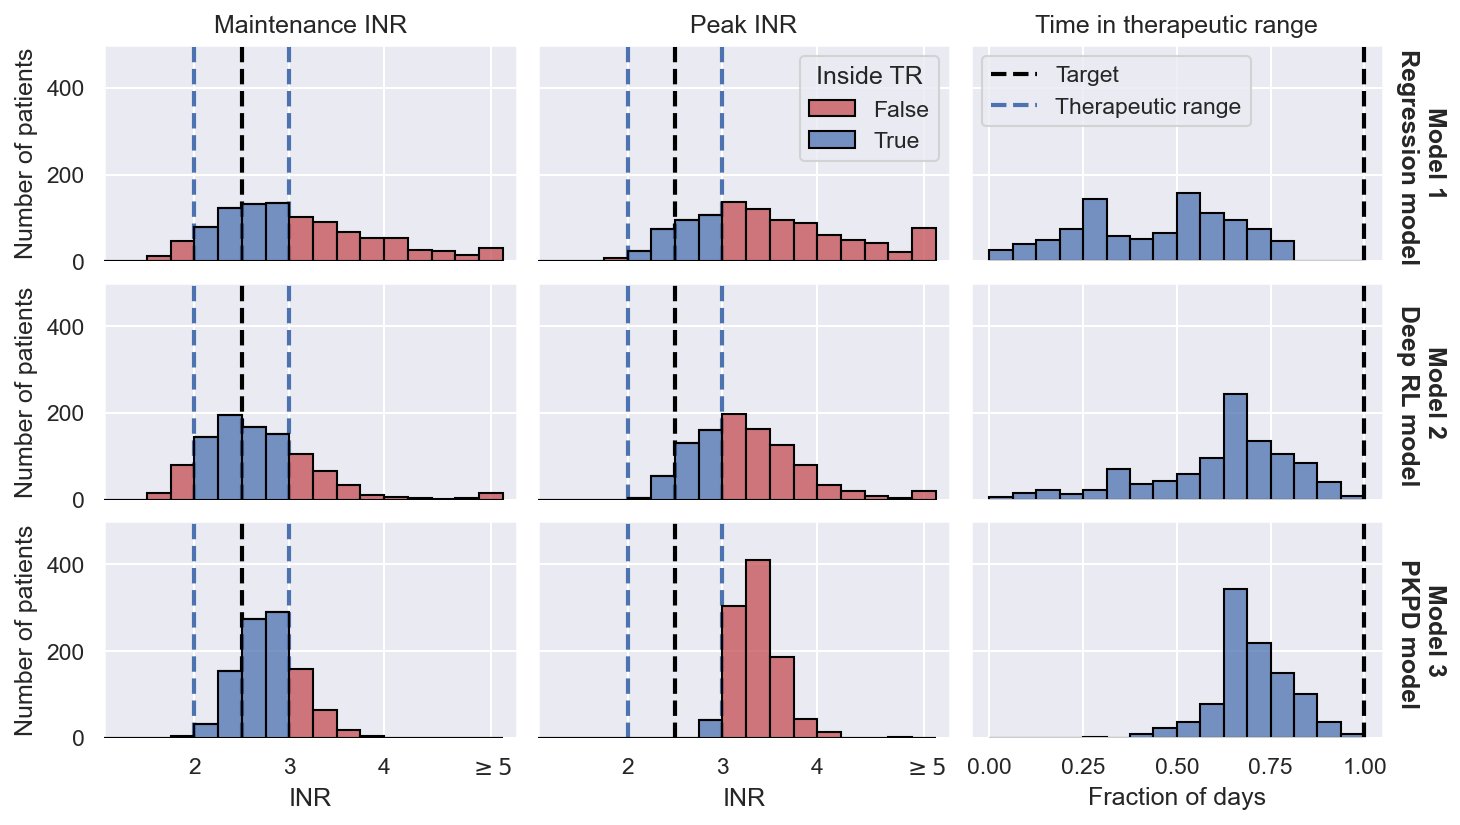

In [63]:
# Visualise results
# Create layout
fontsize = 11
my_dpi = 192
fig = plt.figure(figsize=(2250 // my_dpi, 1200 // my_dpi), dpi=150)
outer = gridspec.GridSpec(3, 1, hspace=0.1)

inner1 = gridspec.GridSpecFromSubplotSpec(
    1, 3, subplot_spec=outer[0], wspace=0.05)
inner2 = gridspec.GridSpecFromSubplotSpec(
    1, 3, subplot_spec=outer[1], wspace=0.05)
inner3 = gridspec.GridSpecFromSubplotSpec(
    1, 3, subplot_spec=outer[2], wspace=0.05)

# Create axes
axes = []
axes.append(plt.Subplot(fig, inner1[2]))
axes.append(plt.Subplot(fig, inner1[1]))
axes.append(plt.Subplot(fig, inner1[0]))
axes.append(plt.Subplot(fig, inner2[2]))
axes.append(plt.Subplot(fig, inner2[1]))
axes.append(plt.Subplot(fig, inner2[0]))
axes.append(plt.Subplot(fig, inner3[2]))
axes.append(plt.Subplot(fig, inner3[1]))
axes.append(plt.Subplot(fig, inner3[0]))

# Add axes to figure
for ax in axes:
    fig.add_subplot(ax)

# Plot time in therapeutic range
inrs_1[inrs_1 > 5] = 5.1
in_tr = (inrs_1 >= 2) & (inrs_1 <= 3)
ttr = np.mean(in_tr, axis=1)
bins2 = np.arange(0, 1.05, 0.0625)
sns.histplot(
    ttr, ax=axes[0], bins=bins2,
    edgecolor='black')
axes[0].axvline(
    x=1, color='black', linestyle='dashed', linewidth=2, label='Target')
axes[0].axvline(
    x=10, color=sns.color_palette()[0], linestyle='dashed', linewidth=2,
    label='Therapeutic range')

# Plot distribution of peak INR
# bins = np.arange(0.125, 8.6, 0.25)
bins = np.arange(1, 5.3, 0.25)
max_inrs = np.max(inrs_1, axis=1)
df = pd.DataFrame({
    'INR': max_inrs, 'Inside TR': (max_inrs>=2) & (max_inrs<=3)})
sns.histplot(
    df, x='INR', hue='Inside TR', ax=axes[1], multiple='stack', bins=bins,
    palette=[sns.color_palette()[3], sns.color_palette()[0]], legend=True,
    edgecolor='black', zorder=10)
axes[1].axvline(x=2.5, color='black', linestyle='dashed', linewidth=2)
axes[1].axvline(
    x=2, color=sns.color_palette()[0], linestyle='dashed', linewidth=2,
    label='TR')
axes[1].axvline(
    x=3, color=sns.color_palette()[0], linestyle='dashed', linewidth=2,
    label='TR')

# # Plot maintenance INR distirbution
final_inrs = inrs_1[:, -1]
df = pd.DataFrame({
    'INR': final_inrs, 'Inside TR': (final_inrs>=2) & (final_inrs<=3)})
sns.histplot(
    df, x='INR', hue='Inside TR', ax=axes[2], multiple='stack', bins=bins,
    palette=[sns.color_palette()[3], sns.color_palette()[0]],
    edgecolor='black', zorder=10, legend=False)
axes[2].axvline(x=2.5, color='black', linestyle='dashed', linewidth=2)
axes[2].axvline(
    x=2, color=sns.color_palette()[0], linestyle='dashed', linewidth=2,
    label='TR')
axes[2].axvline(
    x=3, color=sns.color_palette()[0], linestyle='dashed', linewidth=2,
    label='TR')

# Plot time in therapeutic range
completed_3 = inrs_3[:, :, 1]
completed_3[completed_3 > 5] = 5.1
in_tr = (completed_3 >= 2) & (completed_3 <= 3)
ttr = np.mean(in_tr, axis=1)
sns.histplot(
    ttr, ax=axes[3], bins=bins2,
    edgecolor='black')
axes[3].axvline(x=1, color='black', linestyle='dashed', linewidth=2)

# Plot distribution of peak INR
max_inrs = np.max(completed_3, axis=1)
df = pd.DataFrame({
    'INR': max_inrs, 'Inside TR': (max_inrs>=2) & (max_inrs<=3)})
sns.histplot(
    df, x='INR', hue='Inside TR', ax=axes[4], multiple='stack', bins=bins,
    palette=[sns.color_palette()[3], sns.color_palette()[0]], legend=False,
    edgecolor='black', zorder=10)
axes[4].axvline(x=2.5, color='black', linestyle='dashed', linewidth=2)
axes[4].axvline(
    x=2, color=sns.color_palette()[0], linestyle='dashed', linewidth=2,
    label='TR')
axes[4].axvline(
    x=3, color=sns.color_palette()[0], linestyle='dashed', linewidth=2,
    label='TR')

# Plot maintenance INR distirbution
final_inrs = completed_3[:, -1]
df = pd.DataFrame({
    'INR': final_inrs, 'Inside TR': (final_inrs>=2) & (final_inrs<=3)})
sns.histplot(
    df, x='INR', hue='Inside TR', ax=axes[5], multiple='stack', bins=bins,
    palette=[sns.color_palette()[3], sns.color_palette()[0]], legend=False,
    edgecolor='black', zorder=10)
axes[5].axvline(x=2.5, color='black', linestyle='dashed', linewidth=2)
axes[5].axvline(
    x=2, color=sns.color_palette()[0], linestyle='dashed', linewidth=2,
    label='TR')
axes[5].axvline(
    x=3, color=sns.color_palette()[0], linestyle='dashed', linewidth=2,
    label='TR')

# Plot time in therapeutic range
completed_4 = inrs_4[:, :, 1]
completed_4[completed_4 > 5] = 5.1
in_tr = (completed_4 >= 2) & (completed_4 <= 3)
ttr = np.mean(in_tr, axis=1)
sns.histplot(
    ttr, ax=axes[6], bins=bins2,
    edgecolor='black')
axes[6].axvline(x=1, color='black', linestyle='dashed', linewidth=2)

# Plot distribution of peak INR
max_inrs = np.max(completed_4, axis=1)
df = pd.DataFrame({
    'INR': max_inrs, 'Inside TR': (max_inrs>=2) & (max_inrs<=3)})
sns.histplot(
    df, x='INR', hue='Inside TR', ax=axes[7], multiple='stack', bins=bins,
    palette=[sns.color_palette()[3], sns.color_palette()[0]], legend=False,
    edgecolor='black', zorder=10)
axes[7].axvline(x=2.5, color='black', linestyle='dashed', linewidth=2)
axes[7].axvline(
    x=2, color=sns.color_palette()[0], linestyle='dashed', linewidth=2,
    label='TR')
axes[7].axvline(
    x=3, color=sns.color_palette()[0], linestyle='dashed', linewidth=2,
    label='TR')

# Plot maintenance INR distirbution
final_inrs = completed_4[:, -1]
df = pd.DataFrame({
    'INR': final_inrs, 'Inside TR': (final_inrs>=2) & (final_inrs<=3)})
sns.histplot(
    df, x='INR', hue='Inside TR', ax=axes[8], multiple='stack', bins=bins,
    palette=[sns.color_palette()[3], sns.color_palette()[0]], legend=False,
    edgecolor='black', zorder=10)
axes[8].axvline(x=2.5, color='black', linestyle='dashed', linewidth=2)
axes[8].axvline(
    x=2, color=sns.color_palette()[0], linestyle='dashed', linewidth=2,
    label='TR')
axes[8].axvline(
    x=3, color=sns.color_palette()[0], linestyle='dashed', linewidth=2,
    label='TR')

# Label axes
axes[0].set_xlabel('')
axes[0].set_ylabel('')
axes[0].set_xlim([-0.05, 1.05])
axes[0].set_xticklabels(labels=[], visible=False)
axes[0].set_yticklabels(labels=[], visible=False)
axes[0].set_ylim([0, 499])
axes[1].set_xlabel('')
axes[1].set_xticks([2, 3, 4, 5.125])
axes[1].set_xticklabels(labels=[], visible=False)
axes[1].set_yticklabels(labels=[], visible=False)
axes[1].set_ylabel('')
axes[1].set_xlim([1.05, 5.4])
axes[1].set_ylim([0, 499])
axes[2].set_xlabel('')
axes[2].set_xticks([2, 3, 4, 5.125])
axes[2].set_xticklabels(labels=[], visible=False)
axes[2].set_xlim([1.05, 5.4])
axes[2].set_ylim([0, 499])
axes[2].set_ylabel('Number of patients')
axes[3].set_xlabel('')
axes[3].set_yticklabels(labels=[], visible=False)
axes[3].set_xticklabels(labels=[], visible=False)
axes[3].set_ylabel('')
axes[3].set_xlim([-0.05, 1.05])
axes[3].set_ylim([0, 499])
axes[4].set_xlabel('')
axes[4].set_xticks([2, 3, 4, 5.125])
axes[4].set_xticklabels(labels=[], visible=False)
axes[4].set_yticklabels(labels=[], visible=False)
axes[4].set_ylabel('')
axes[4].set_xlim([1.05, 5.4])
axes[4].set_ylim([0, 499])
axes[5].set_xlabel('')
axes[5].set_ylabel('Number of patients')
axes[5].set_xticks([2, 3, 4, 5.125])
axes[5].set_xticklabels(labels=[], visible=False)
axes[5].set_xlim([1.05, 5.4])
axes[5].set_ylim([0, 499])
axes[6].set_xlabel('Fraction of days')
axes[6].set_ylabel('')
axes[6].set_yticklabels(labels=[], visible=False)
axes[6].set_xlim([-0.05, 1.05])
axes[6].set_ylim([0, 499])
axes[7].set_xlabel('INR')
axes[7].set_ylabel('')
axes[7].set_yticklabels(labels=[], visible=False)
axes[7].set_xticks([2, 3, 4, 5.125])
axes[7].set_xticklabels(labels=['2', '3', '4', r'$\geq5$'])
axes[7].set_xlim([1.05, 5.4])
axes[7].set_ylim([0, 499])
axes[8].set_xlabel('INR')
axes[8].set_xlim([1.05, 5.4])
axes[8].set_ylim([0, 499])
axes[8].set_ylabel('Number of patients')
axes[8].set_xticks([2, 3, 4, 5.125])
axes[8].set_xticklabels(labels=['2', '3', '4', r'$\geq5$'])

axes[0].legend()

axes[0].set_title('Time in therapeutic range')
axes[1].set_title('Peak INR')
axes[2].set_title('Maintenance INR')

axes[0].yaxis.set_label_position("right")
axes[0].set_ylabel(
    'Model 1\n Regression model', rotation=-90, labelpad=30, fontweight='bold')
axes[3].yaxis.set_label_position("right")
axes[3].set_ylabel(
    'Model 2\n Deep RL model', rotation=-90, labelpad=30, fontweight='bold')
axes[6].yaxis.set_label_position("right")
axes[6].set_ylabel(
    'Model 3\n PKPD model', rotation=-90, labelpad=30, fontweight='bold')

plt.savefig('10_mipd_trial_results.pdf',
    bbox_inches='tight')
plt.savefig('10_mipd_trial_results.tif',
    bbox_inches='tight')

plt.show()

In [58]:
np.sum((completed_1[:, -1] >= 2) & (completed_1[:, -1] <= 3))

470

In [59]:
max_inrs = np.max(completed_1, axis=1)
np.sum(max_inrs > 3)

671

In [60]:
in_tr = (completed_1 >= 2) & (completed_1 <= 3)
ttr = np.mean(in_tr, axis=1)
np.median(ttr)

0.45

In [61]:
np.max(ttr)

0.85

## Visualise dosing strategies

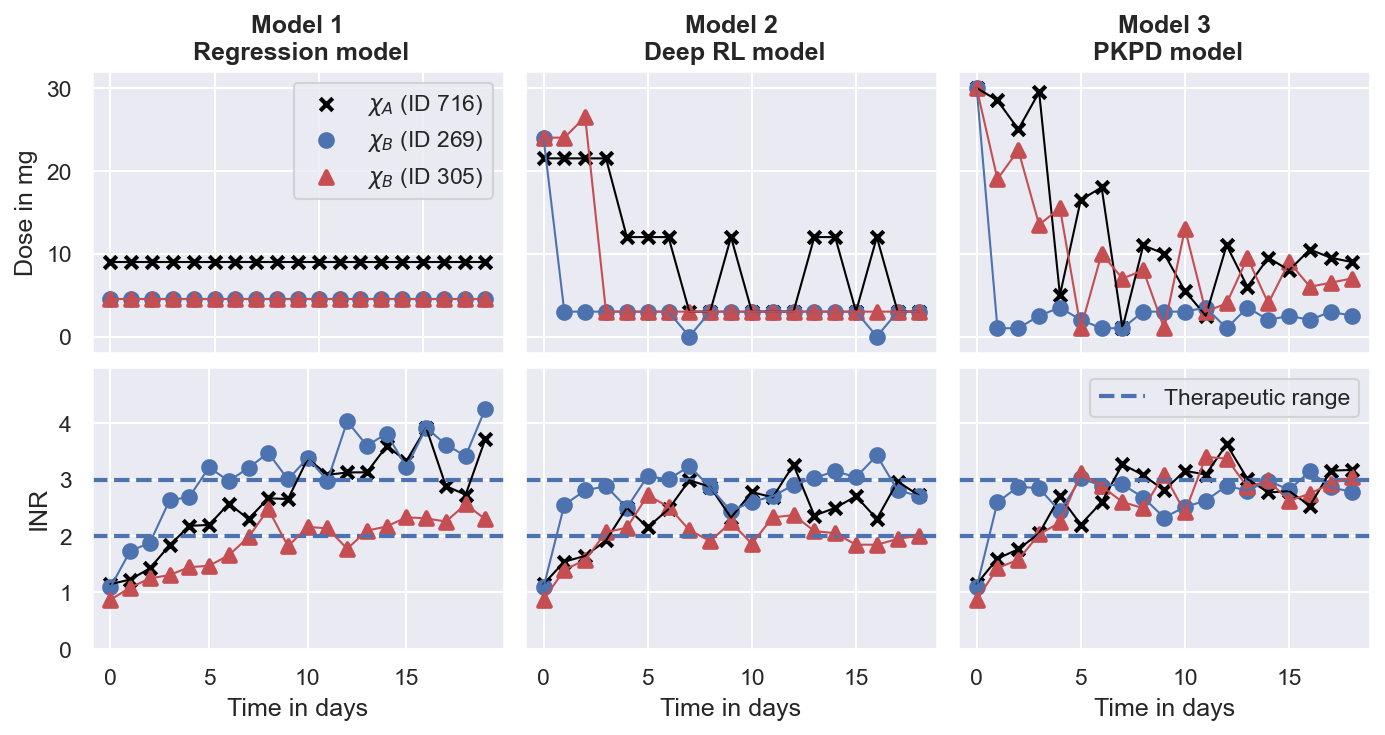

In [152]:
# Visualise results
# Create layout
fontsize = 11
my_dpi = 192
fig = plt.figure(figsize=(2250 // my_dpi, 1000 // my_dpi), dpi=150)
outer = gridspec.GridSpec(1, 3, wspace=0.05)

inner1 = gridspec.GridSpecFromSubplotSpec(
    2, 1, subplot_spec=outer[0], hspace=0.05)
inner2 = gridspec.GridSpecFromSubplotSpec(
    2, 1, subplot_spec=outer[1], hspace=0.05)
inner3 = gridspec.GridSpecFromSubplotSpec(
    2, 1, subplot_spec=outer[2], hspace=0.05)

# Create axes
axes = []
axes.append(plt.Subplot(fig, inner1[0]))
axes.append(plt.Subplot(fig, inner1[1]))
axes.append(plt.Subplot(fig, inner2[0]))
axes.append(plt.Subplot(fig, inner2[1]))
axes.append(plt.Subplot(fig, inner3[0]))
axes.append(plt.Subplot(fig, inner3[1]))

# Add axes to figure
for ax in axes:
    fig.add_subplot(ax)

axes[1].axhline(2, linestyle='--', color=sns.color_palette()[0], linewidth=2)
axes[1].axhline(3, linestyle='--', color=sns.color_palette()[0], linewidth=2)
axes[3].axhline(2, linestyle='--', color=sns.color_palette()[0], linewidth=2)
axes[3].axhline(3, linestyle='--', color=sns.color_palette()[0], linewidth=2)
axes[5].axhline(2, linestyle='--', color=sns.color_palette()[0], linewidth=2)
axes[5].axhline(
    3, linestyle='--', color=sns.color_palette()[0], linewidth=2,
    label='Therapeutic range')

# Model 1
ids = df_demo[
    (df_demo.CYP2C9 == 1)
    & (df_demo.Age > 50)
    & (df_demo.Age < 51)
    & (df_demo.VKORC1 == 1)
].ID.values[[5, 0, 1,]] - 1
ids[0] = df_demo[
    (df_demo.CYP2C9 == 0)
    & (df_demo.Age > 50)
    & (df_demo.Age < 51)
    & (df_demo.VKORC1 == 0)
].ID.values[2] - 1
inrs_1[ids[0]][0] = inrs_3[ids[0], 0, 1]
inrs_1[ids[1]][0] = inrs_3[ids[1], 0, 1]
inrs_1[ids[2]][0] = inrs_3[ids[2], 0, 1]
axes[0].plot(
    times[:-1] / 24 - 100, doses[ids[0]], color='black', linewidth=1)
axes[0].scatter(
    times[:-1] / 24 - 100, doses[ids[0]], marker='x',
    color='black', linewidths=2, label=r'$\chi _A$ ' + f'(ID {ids[0]})')
axes[1].plot(
    times / 24 - 100, inrs_1[ids[0]], color='black', linewidth=1)
axes[1].scatter(
    times / 24 - 100, inrs_1[ids[0]], marker='x',
    color='black', linewidths=2)
axes[0].plot(
    times[:-1] / 24 - 100, doses[ids[1]], color=sns.color_palette()[0],
    linewidth=1)
axes[0].scatter(
    times[:-1] / 24 - 100, doses[ids[1]], marker='o',
    color=sns.color_palette()[0], linewidths=2,
    label=r'$\chi _B$ ' + f'(ID {ids[1]})')
axes[1].plot(
    times / 24 - 100, inrs_1[ids[1]], color=sns.color_palette()[0],
    linewidth=1)
axes[1].scatter(
    times / 24 - 100, inrs_1[ids[1]], marker='o',
    color=sns.color_palette()[0], linewidths=2)
axes[0].plot(
    times[:-1] / 24 - 100, doses[ids[2]], color=sns.color_palette()[3],
    linewidth=1)
axes[0].scatter(
    times[:-1] / 24 - 100, doses[ids[2]], marker='^',
    color=sns.color_palette()[3], linewidths=2,
    label=r'$\chi _B$ ' + f'(ID {ids[2]})')
axes[1].plot(
    times / 24 - 100, inrs_1[ids[2]], color=sns.color_palette()[3],
    linewidth=1)
axes[1].scatter(
    times / 24 - 100, inrs_1[ids[2]], marker='^',
    color=sns.color_palette()[3], linewidths=2)

# Model 2
axes[2].plot(
    inrs_3[ids[0], :, 0], inrs_3[ids[0], :, 2], color='black', linewidth=1)
axes[2].scatter(
    inrs_3[ids[0], :, 0], inrs_3[ids[0], :, 2], marker='x',
    color='black', linewidths=2)
axes[3].plot(
    inrs_3[ids[0], :, 0], inrs_3[ids[0], :, 1], color='black', linewidth=1)
axes[3].scatter(
    inrs_3[ids[0], :, 0], inrs_3[ids[0], :, 1], marker='x',
    color='black', linewidths=2)
axes[2].plot(
    inrs_3[ids[1], :, 0], inrs_3[ids[1], :, 2], color=sns.color_palette()[0],
    linewidth=1)
axes[2].scatter(
    inrs_3[ids[1], :, 0], inrs_3[ids[1], :, 2], marker='o',
    color=sns.color_palette()[0], linewidths=2)
axes[3].plot(
    inrs_3[ids[1], :, 0], inrs_3[ids[1], :, 1], color=sns.color_palette()[0],
    linewidth=1)
axes[3].scatter(
    inrs_3[ids[1], :, 0], inrs_3[ids[1], :, 1], marker='o',
    color=sns.color_palette()[0], linewidths=2)
axes[2].plot(
    inrs_3[ids[2], :, 0], inrs_3[ids[2], :, 2], color=sns.color_palette()[3],
    linewidth=1)
axes[2].scatter(
    inrs_3[ids[2], :, 0], inrs_3[ids[2], :, 2], marker='^',
    color=sns.color_palette()[3], linewidths=2)
axes[3].plot(
    inrs_3[ids[2], :, 0], inrs_3[ids[2], :, 1], color=sns.color_palette()[3],
    linewidth=1)
axes[3].scatter(
    inrs_3[ids[2], :, 0], inrs_3[ids[2], :, 1], marker='^',
    color=sns.color_palette()[3], linewidths=2)

# Model 3
axes[4].plot(
    inrs_4[ids[0], :, 0], inrs_4[ids[0], :, 2], color='black', linewidth=1)
axes[4].scatter(
    inrs_4[ids[0], :, 0], inrs_4[ids[0], :, 2], marker='x',
    color='black', linewidths=2)
axes[5].plot(
    inrs_4[ids[0], :, 0], inrs_4[ids[0], :, 1], color='black', linewidth=1)
axes[5].scatter(
    inrs_4[ids[0], :, 0], inrs_4[ids[0], :, 1], marker='x',
    color='black', linewidths=2)
axes[4].plot(
    inrs_4[ids[1], :, 0], inrs_4[ids[1], :, 2], color=sns.color_palette()[0],
    linewidth=1)
axes[4].scatter(
    inrs_4[ids[1], :, 0], inrs_4[ids[1], :, 2], marker='o',
    color=sns.color_palette()[0], linewidths=2)
axes[5].plot(
    inrs_4[ids[1], :, 0], inrs_4[ids[1], :, 1], color=sns.color_palette()[0],
    linewidth=1)
axes[5].scatter(
    inrs_4[ids[1], :, 0], inrs_4[ids[1], :, 1], marker='o',
    color=sns.color_palette()[0], linewidths=2)
axes[4].plot(
    inrs_4[ids[2], :, 0], inrs_4[ids[2], :, 2], color=sns.color_palette()[3],
    linewidth=1)
axes[4].scatter(
    inrs_4[ids[2], :, 0], inrs_4[ids[2], :, 2], marker='^',
    color=sns.color_palette()[3], linewidths=2)
axes[5].plot(
    inrs_4[ids[2], :, 0], inrs_4[ids[2], :, 1], color=sns.color_palette()[3],
    linewidth=1)
axes[5].scatter(
    inrs_4[ids[2], :, 0], inrs_4[ids[2], :, 1], marker='^',
    color=sns.color_palette()[3], linewidths=2)

axes[0].set_ylabel('Dose in mg')
axes[0].set_xticklabels([], visible=False)
axes[1].set_ylabel('INR')
axes[1].set_xlabel('Time in days')
axes[3].set_xlabel('Time in days')
axes[5].set_xlabel('Time in days')
axes[0].set_ylim([-2, 32])
axes[1].set_ylim([0, 4.99])
axes[2].set_ylim([-2, 32])
axes[2].set_xticklabels([], visible=False)
axes[2].set_yticklabels([], visible=False)
axes[3].set_ylim([0, 4.99])
axes[3].set_yticklabels([], visible=False)
axes[4].set_ylim([-2, 32])
axes[4].set_xticklabels([], visible=False)
axes[4].set_yticklabels([], visible=False)
axes[5].set_ylim([0, 4.99])
axes[5].set_yticklabels([], visible=False)
axes[0].set_title(
    'Model 1\n Regression model', fontweight='bold')
axes[2].set_title(
    'Model 2\n Deep RL model', fontweight='bold')
axes[4].set_title(
    'Model 3\n PKPD model', fontweight='bold')

axes[0].legend()
axes[5].legend()

plt.savefig('11_dosing_strategies.pdf',
    bbox_inches='tight')
plt.savefig('11_dosing_strategies.tif',
    bbox_inches='tight')

plt.show()

In [222]:
np.mean(np.std(inrs_1[ids[[0, 1, 2]]][:, 10:], ddof=1, axis=0))

0.7642880310797304

In [230]:
np.mean(np.std(inrs_3[ids[[0, 1, 2]], :, 1][:, 10:], ddof=1, axis=0))

0.5075569026334295

In [231]:
np.mean(np.std(inrs_4[ids[[0, 1, 2]], :, 1][:, 10:], ddof=1, axis=0))

0.23976021977691467

## Understanding DQN

In [212]:
# Load policy
directory = os.path.dirname(os.getcwd())
data = pd.read_csv(
    directory + '/4_reinforcement_learning'
    '/policy.csv')
policy_1 = {}
for idx in range(3):
    if idx == 0:
        label = r'$\chi _A$'
        temp = data[
            (data['VKORC1 G alleles'] == 1) &
            (data['CYP2C9 1 alleles'] == 1)
        ]
    elif idx == 1:
        label = r'$\chi _B$ 1'
        temp = data[
            (data['VKORC1 G alleles'] == 0.5) &
            (data['CYP2C9 1 alleles'] == 0.5) &
            (data['CYP2C9 2 alleles'] == 0.5)
        ]
    else:
        label = r'$\chi _B$ 2'
        temp = data[
            (data['VKORC1 G alleles'] == 0.5) &
            (data['CYP2C9 1 alleles'] == 0.5) &
            (data['CYP2C9 2 alleles'] == 0.5)
        ]

    policy_1[label] = temp[['INR', 'Dose']].values

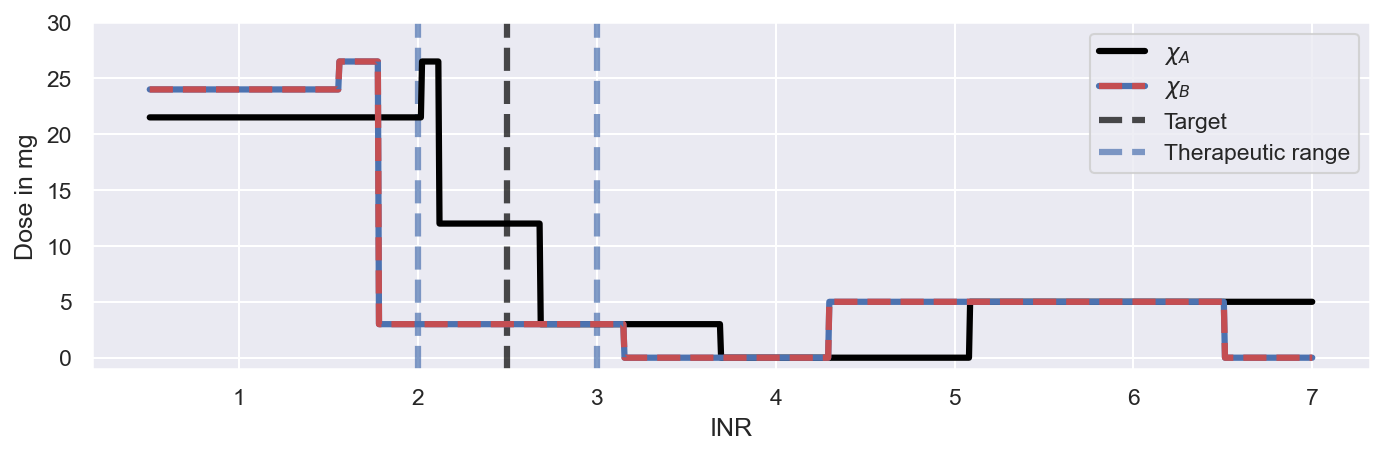

In [213]:
# Create layout
fontsize = 11
my_dpi = 192
fig = plt.figure(figsize=(2250 // my_dpi, 700 // my_dpi), dpi=150)
outer = gridspec.GridSpec(1, 1)

# Create axes
axes = []
axes.append(plt.Subplot(fig, outer[0]))

# Add axes to figure
for ax in axes:
    fig.add_subplot(ax)

colors = ['black', sns.color_palette()[0], sns.color_palette()[3]]
ls = ['solid', 'solid', '--']
lines = []
for idl, label in enumerate(policy_1.keys()):
    l, = axes[0].plot(
        policy_1[label][:, 0], policy_1[label][:, 1], label=label,
        color=colors[idl], linewidth=3, linestyle=ls[idl], zorder=10)
    lines.append(l)
l = axes[0].axvline(
    2.5, linestyle='--', color='black', linewidth=3, label='Target', alpha=0.7)
lines.append(l)
l = axes[0].axvline(
    2, linestyle='--', color=sns.color_palette()[0], linewidth=3,
    label='Therapeutic range', alpha=0.7)
lines.append(l)
axes[0].axvline(
    3, linestyle='--', color=sns.color_palette()[0], linewidth=3, alpha=0.7)

# Label axes
axes[0].set_xlabel('INR')
axes[0].set_ylabel('Dose in mg')
axes[0].set_ylim([-1, 30])

axes[0].legend(
    [lines[0], (lines[1], lines[2]), lines[3], lines[4]],
    [r'$\chi _A$', r'$\chi _B$', 'Target', 'Therapeutic range']
)

plt.savefig('12_dqn_dosing_policy.pdf',
    bbox_inches='tight')
plt.savefig('12_dqn_dosing_policy.tif',
    bbox_inches='tight')

plt.show()

## Understanding PKPD model

In [307]:
ids = df_demo[
    (df_demo.CYP2C9 == 1)
    & (df_demo.Age > 50)
    & (df_demo.Age < 51)
    & (df_demo.VKORC1 == 1)
].ID.values[[5, 0, 1,]] - 1
ids[0] = df_demo[
    (df_demo.CYP2C9 == 0)
    & (df_demo.Age > 50)
    & (df_demo.Age < 51)
    & (df_demo.VKORC1 == 0)
].ID.values[2] - 1

n_data = [1, 2, 7, 16]
n = len(n_data)
nids = len(ids)
days = 19
dosing_regimens = np.empty(shape=(nids, n, days))
for idn, n in enumerate(n_data):
    # Load dosing strategy
    directory = os.path.dirname(os.getcwd())
    df_doses = pd.read_csv(
        directory + '/2_semi_mechanistic_model'
        '/mipd_trial_predicted_dosing_regimens.csv')
    df_doses = df_doses[df_doses['Number of observations'] == n]

    # Get dosages
    for idx, _id in enumerate(ids):
        temp = df_doses[df_doses.ID == (_id + 1)]
        dosing_regimens[idx, idn] = \
            temp[['Dose %d in mg' % (idx+1) for idx in range(days)]].values[0]

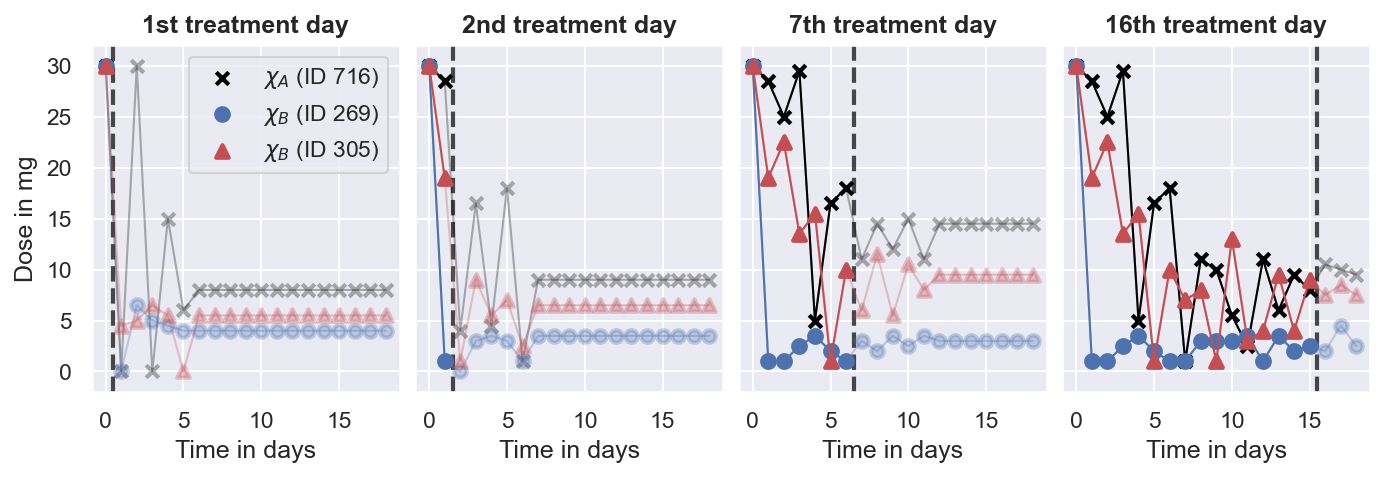

In [308]:
# Visualise results
# Create layout
fontsize = 11
my_dpi = 192
fig = plt.figure(figsize=(2250 // my_dpi, 700 // my_dpi), dpi=150)
outer = gridspec.GridSpec(1, 4, wspace=0.05)

# Create axes
axes = []
axes.append(plt.Subplot(fig, outer[0]))
axes.append(plt.Subplot(fig, outer[1]))
axes.append(plt.Subplot(fig, outer[2]))
axes.append(plt.Subplot(fig, outer[3]))

# Add axes to figure
for ax in axes:
    fig.add_subplot(ax)

# Plot dosages
times = np.arange(days)
for idn, n in enumerate(n_data):
    alpha = 0.3
    axes[idn].plot(
        times, dosing_regimens[0, idn], color='black', linewidth=1,
        alpha=alpha, zorder=10)
    axes[idn].scatter(
        times, dosing_regimens[0, idn], marker='x',
        color='black', linewidths=2, alpha=alpha, zorder=10)
    axes[idn].plot(
        times, dosing_regimens[1, idn], color=sns.color_palette()[0],
        linewidth=1, alpha=alpha, zorder=10)
    axes[idn].scatter(
        times, dosing_regimens[1, idn], marker='o',
        color=sns.color_palette()[0], linewidths=2, alpha=alpha, zorder=10)
    axes[idn].plot(
        times, dosing_regimens[2, idn], color=sns.color_palette()[3],
        linewidth=1, alpha=alpha, zorder=10)
    axes[idn].scatter(
        times, dosing_regimens[2, idn], marker='^',
        color=sns.color_palette()[3], linewidths=2, alpha=alpha, zorder=10)

    alpha = 1
    axes[idn].plot(
        times[:n], dosing_regimens[0, idn, :n], color='black', linewidth=1,
        alpha=alpha, zorder=10)
    axes[idn].scatter(
        times[:n], dosing_regimens[0, idn, :n], marker='x',
        color='black', linewidths=2, alpha=alpha, zorder=10,
        label=r'$\chi _A$ ' + f'(ID {ids[0]})')
    axes[idn].plot(
        times[:n], dosing_regimens[1, idn, :n], color=sns.color_palette()[0],
        linewidth=1, alpha=alpha, zorder=10)
    axes[idn].scatter(
        times[:n], dosing_regimens[1, idn, :n], marker='o',
        color=sns.color_palette()[0], linewidths=2, alpha=alpha, zorder=10,
        label=r'$\chi _B$ ' + f'(ID {ids[1]})')
    axes[idn].plot(
        times[:n], dosing_regimens[2, idn, :n], color=sns.color_palette()[3],
        linewidth=1, alpha=alpha, zorder=10)
    axes[idn].scatter(
        times[:n], dosing_regimens[2, idn, :n], marker='^',
        color=sns.color_palette()[3], linewidths=2, alpha=alpha, zorder=10,
        label=r'$\chi _B$ ' + f'(ID {ids[2]})')

    axes[idn].axvline(
        times[:n][-1]+0.5, linestyle='--', color='black',
        linewidth=2, alpha=0.7)

axes[0].legend()

axes[0].set_ylim([-2, 32])
axes[1].set_ylim([-2, 32])
axes[1].set_yticklabels([], visible=False)
axes[2].set_ylim([-2, 32])
axes[2].set_yticklabels([], visible=False)
axes[3].set_ylim([-2, 32])
axes[3].set_yticklabels([], visible=False)

axes[0].set_ylabel('Dose in mg')
axes[0].set_xlabel('Time in days')
axes[1].set_xlabel('Time in days')
axes[2].set_xlabel('Time in days')
axes[3].set_xlabel('Time in days')

axes[0].set_title(
    '1st treatment day', fontweight='bold')
axes[1].set_title(
    '2nd treatment day', fontweight='bold')
axes[2].set_title(
    '7th treatment day', fontweight='bold')
axes[3].set_title(
    '16th treatment day', fontweight='bold')

plt.savefig('12_pkpd_model_dosing_strategy.pdf',
    bbox_inches='tight')
plt.savefig('12_pkpd_model_dosing_strategy.tif',
    bbox_inches='tight')

plt.show()

## Virtual clinical trial data used for calibration

/var/folders/v4/97p50d2s59d8tf5xm5h27fjh0000gp/T/ipykernel_98447/725042677.py:94: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  inrs_3[idx] = temp[temp.ID == _id].Value.values


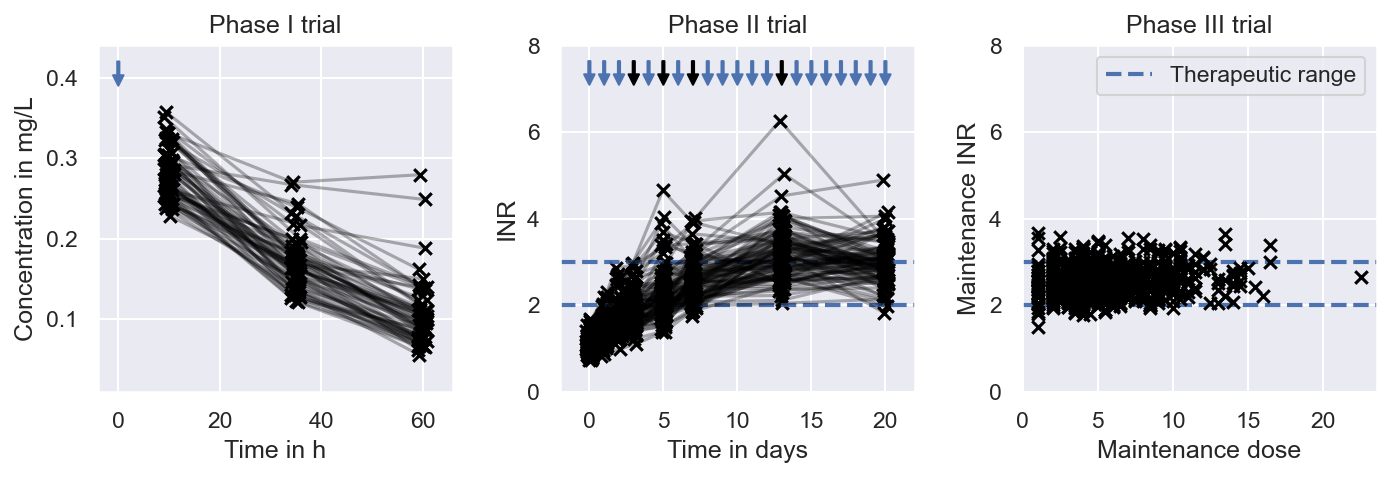

In [9]:
# Visualise results
# Create layout
fontsize = 11
my_dpi = 192
fig = plt.figure(figsize=(2250 // my_dpi, 700 // my_dpi), dpi=150)
outer = gridspec.GridSpec(1, 3, wspace=0.3)

# Create axes
axes = []
axes.append(plt.Subplot(fig, outer[0]))
axes.append(plt.Subplot(fig, outer[1]))
axes.append(plt.Subplot(fig, outer[2]))


# Add axes to figure
for ax in axes:
    fig.add_subplot(ax)

axes[2].sharey(axes[1])

# Visualise trial phase I
directory = os.path.dirname(os.getcwd())
data = pd.read_csv(directory + '/data/trial_phase_I.csv')
data = data[data.Observable == 'central_warfarin.warfarin_concentration']
ids = data.ID.dropna().unique()
times = data.Time.dropna().unique()
concs = np.empty(shape=(len(ids), len(times)))
for idx, _id in enumerate(ids):
    concs[idx] = data[data.ID == _id].Value.values
for c in concs:
    jitter = np.random.uniform(-1, 1, size=len(times))
    axes[0].plot(
        times + jitter, c, marker='x', color='black',
        alpha=0.3)
    axes[0].scatter(
        times + jitter, c, marker='x', color='black')

# Visualise dose point
axes[0].annotate(
    "", xy=(0, 0.39), xytext=(0, 0.42),
    arrowprops=dict(width=1, headwidth=5, headlength=5,
    color=sns.color_palette()[0]))

# Visualise therapeutic range
axes[1].axhline(
    2, linestyle='--', color=sns.color_palette()[0], linewidth=2)
axes[1].axhline(
    3, linestyle='--', color=sns.color_palette()[0], linewidth=2)
axes[2].axhline(
    2, linestyle='--', color=sns.color_palette()[0], linewidth=2)
axes[2].axhline(
    3, linestyle='--', color=sns.color_palette()[0], linewidth=2,
    label='Therapeutic range')

# Visualise trial phase II
data = pd.read_csv(directory + '/data/trial_phase_II.csv')
temp = data[data.Observable == 'INR']
ids = temp.ID.dropna().unique()
times2 = temp.Time.dropna().unique() // 24
inrs2 = np.empty(shape=(len(ids), len(times2)))
for idx, _id in enumerate(ids):
    inrs2[idx] = temp[temp.ID == _id].Value.values
    mask = data.ID == _id
for c in inrs2:
    jitter = np.random.uniform(-0.2, 0.2, size=len(times2))
    axes[1].plot(
        times2 + jitter, c, marker='x', color='black',
        alpha=0.3)
    axes[1].scatter(
        times2 + jitter, c, marker='x', color='black')

# Visualise dose point
for t in range(21):
    color = sns.color_palette()[0]
    if t in [3, 5, 7, 13]:
        color = 'black'
    axes[1].annotate(
        "", xy=(t, 0.39 / 0.44 * 8), xytext=(t, 0.42 / 0.44 * 8),
        arrowprops=dict(width=1, headwidth=5, headlength=5,
        color=color)
    )

# Visualise trial phase III
data = pd.read_csv(directory + '/data/trial_phase_III.csv')
mask = \
    (data.Observable != 'INR') | (
    (data.Observable == 'INR') & (data.Time == 1320))
data = data[mask]
temp = data[data.Observable == 'INR']
ids = temp.ID.dropna().unique()
inrs_3 = np.empty(shape=len(ids))
doses_3 = np.empty(shape=(len(ids)))
for idx, _id in enumerate(ids):
    inrs_3[idx] = temp[temp.ID == _id].Value.values
    mask = data.ID == _id
    doses_3[idx] = data[mask].Dose.dropna().values[-1]
axes[2].scatter(
    doses_3, inrs_3, marker='x', color='black', zorder=10)


axes[0].set_title('Phase I trial')
axes[1].set_title('Phase II trial')
axes[2].set_title('Phase III trial')

# Label axes
axes[0].set_xlabel('Time in h')
axes[0].set_ylabel('Concentration in mg/L')
axes[0].set_xlim([-4, 66])
axes[0].set_ylim([0.01, 0.44])

axes[1].set_xlabel('Time in days')
axes[1].set_ylabel('INR')
axes[1].set_xlim([-2, 22])
axes[1].set_ylim([0, 8])

axes[2].set_xlabel('Maintenance dose')
axes[2].set_ylabel('Maintenance INR')

axes[2].legend()

plt.savefig('14_phase_I_II_III.pdf',
    bbox_inches='tight')
plt.savefig('14_phase_I_II_III.tif',
    bbox_inches='tight')

plt.show()